In [1]:
# %% Cell 1 - Imports e configurações básicas
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score,
    accuracy_score, confusion_matrix, classification_report
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
import joblib
import lightgbm as lgb

# Configurações
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Carregar dados
caminho = "/Users/renanmoura/Documents/mestrado/PE-AI/data/dados.xlsx"
df = pd.read_excel(caminho)
print("Shape original:", df.shape)

# Verificar coluna alvo
target_col = "PreEclampsia"
if target_col not in df.columns:
    print("Colunas disponíveis:", list(df.columns))
    raise ValueError(f"Coluna alvo '{target_col}' não encontrada.")

display(df.head())

Shape original: (571, 59)


,PacienteId,Data,peso,imc,diabetes,hipertensao,dataNascimento,dataProvavelParto,pesoPrimeiroTrimestre,origemRacial,...,ComprimentoNascimento,PerimetroCefalico,Apgar1Minuto,Apgar5Minutos,DiasHospital,Intercorrencias,TipoDiabetes,PrimeiroPesoGravidez,DataParto,DataPesoCartao
0,44,25/11/2024,81,31.64,Sim,Não,1989-06-16,NaN,NaN,NaN,...,50.0,36.0,8.0,9.0,2.0,NaN,Diabetes Gestacional,72,45634.0,45629.0
1,44,11/06/2024,76,29.69,NaN,Não,NaN,NaN,NaN,Pardo,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,44,07/05/2024,NaN,NaN,NaN,NaN,NaN,2024-12-19,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,44,12/05/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,168,11/12/2024,105,38.57,Sim,Não,1990-07-26,NaN,NaN,NaN,...,46.0,34.5,8.0,9.0,1.0,NaN,Diabetes Gestacional,105,45641.0,45637.0


In [2]:
# %% Cell 2 - Pré-processamento otimizado
print("=== PRÉ-PROCESSAMENTO ===")

# Mapas de conversão
map_raca = {"Branco": 1, "Pardo": 2, "Preto": 3}
map_boolean = {"Sim": 1, "YES": 1, "SIM": 1, "TRUE": 1, "Nao": 1, "NAO": 0, "Não": 0, "NÃO": 0, "FALSE": 0}
map_hist_diabetes = {"Não": 0, "NAO": 0, "NÃO": 0, "Nao": 0, "1º grau": 3, "1° GRAU": 3, "1 GRAU": 3, "2º grau": 2, "2° GRAU": 2, "2 GRAU": 2, "3º grau": 1, "3° GRAU": 1, "3 GRAU": 1}

# Lista final das 24 features
input_features = [
    "peso", "imc", "diabetes", "hipertensao", "pesoPrimeiroTrimestre",
    "origemRacial", "historicoFamiliarDiabetes", "mediaIP", 
    "historiaObstetricaAnterior", "perdasGestacionais", "fuma", 
    "idadeGestacional2", "idadeGestacionalCorrigida2", "pesoFetal", 
    "percentilArteriaUterina", "percentilPeso", "temHipertensaoPreExistente", 
    "temEndometriose", "temHipotireoidismo", "temIIC", "temTrombofilia", 
    "temRetocolite", "temGastrite", "temOutraDoenca"
]

# Aplicar transformações básicas
df_processed = df.copy()

# 1. Converter raça (sem downcasting)
if "origemRacial" in df_processed.columns:
    df_processed["origemRacial"] = df_processed["origemRacial"].replace(map_raca).astype(float)

# 2. Converter booleanos (sem downcasting)
cols_bool = ["diabetes", "fuma", "PreEclampsia", "hipertensao"]
for col in cols_bool:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].replace(map_boolean).astype(float)

# 3. Histórico diabetes
if "historicoFamiliarDiabetes" in df_processed.columns:
    df_processed["historicoFamiliarDiabetes"] = (df_processed["historicoFamiliarDiabetes"]
                                                .astype(str).str.strip().replace(map_hist_diabetes).astype(float))

# 4. Histórico obstétrico (simplificado)
if "historiaObstetricaAnterior" in df_processed.columns:
    df_processed["historiaObstetricaAnterior"] = pd.to_numeric(df_processed["historiaObstetricaAnterior"], errors='coerce')

# 5. Perdas gestacionais (simplificado)
if "perdasGestacionais" in df_processed.columns:
    df_processed["perdasGestacionais"] = pd.to_numeric(df_processed["perdasGestacionais"], errors='coerce')

# 6. CRIAR COLUNAS FALTANTES PARA DOENÇAS
# Inicializar todas as colunas de doenças como 0
doenca_cols = ["temHipertensaoPreExistente", "temEndometriose", "temHipotireoidismo", 
               "temIIC", "temTrombofilia", "temRetocolite", "temGastrite", "temOutraDoenca"]

for col in doenca_cols:
    df_processed[col] = 0

# Tentar extrair informações de colunas existentes sobre doenças
if "doencaPreExistente" in df_processed.columns:
    doenca_text = df_processed["doencaPreExistente"].astype(str).str.lower()
    
    # Preencher baseado no texto das doenças preexistentes
    df_processed["temHipertensaoPreExistente"] = doenca_text.str.contains("hipertens", na=False).astype(int)
    df_processed["temEndometriose"] = doenca_text.str.contains("endometriose", na=False).astype(int)
    df_processed["temHipotireoidismo"] = doenca_text.str.contains("hipotireoid", na=False).astype(int)
    df_processed["temTrombofilia"] = doenca_text.str.contains("trombofilia", na=False).astype(int)
    df_processed["temGastrite"] = doenca_text.str.contains("gastrite", na=False).astype(int)
    
    # Outras doenças (para temOutraDoenca)
    outras_condicoes = doenca_text.str.contains("diabetes|asma|depress|ansiedade|outra", na=False)
    df_processed["temOutraDoenca"] = (outras_condicoes & 
                                     ~df_processed[["temHipertensaoPreExistente", "temEndometriose", 
                                                   "temHipotireoidismo", "temTrombofilia", "temGastrite"]].any(axis=1)).astype(int)

# 7. Converter todas as features para numérico e preencher NaNs
print("Convertendo features para numérico...")
for col in input_features:
    if col in df_processed.columns:
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
    else:
        print(f"⚠️  Coluna {col} não encontrada, criando com valor 0")
        df_processed[col] = 0

# 8. Preencher NaNs com valores apropriados (evitando medianas de arrays vazios)
print("Preenchendo valores faltantes...")
for col in input_features:
    if df_processed[col].isna().any():
        na_count = df_processed[col].isna().sum()
        # Usar moda para colunas categóricas, 0 para outras
        if col in ['historiaObstetricaAnterior', 'perdasGestacionais', 'origemRacial']:
            fill_val = df_processed[col].mode()[0] if not df_processed[col].mode().empty else 0
        else:
            fill_val = 0
        
        df_processed[col] = df_processed[col].fillna(fill_val)
        print(f"  - {col}: {na_count} NaNs preenchidos com {fill_val}")

def aplicar_limites_realistas(X, feature_names):
    limites = {
        "peso": (40, 150),                 # kg
        "imc": (15, 50),                   # IMC
        "pesoPrimeiroTrimestre": (35, 150),
        "pesoFetal": (0, 5000),            # gramas
    }
    X = X.copy()
    for feat, (low, high) in limites.items():
        if feat in feature_names:
            X[feat] = X[feat].clip(lower=low, upper=high)
    return X

df_processed[input_features] = aplicar_limites_realistas(
    df_processed[input_features],
    input_features
)


# 9. Garantir que todas as colunas são numéricas
for col in input_features:
    df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce').fillna(0)

# 10. Garantir target
df_processed = df_processed[~df_processed[target_col].isna()]
df_processed[target_col] = df_processed[target_col].astype(int)

print("\n=== ESTATÍSTICAS PÓS-PRÉ-PROCESSAMENTO ===")
for col in ["peso", "imc", "diabetes", "hipertensao", "pesoPrimeiroTrimestre", "pesoFetal"]:
    if col in input_features:
        vals = df_processed[col]
        print(f"{col}: min={vals.min():.2f}, max={vals.max():.2f}, mean={vals.mean():.2f}")

print(f"\n✅ Pré-processamento concluído")
print(f"Shape após pré-processamento: {df_processed.shape}")
print(f"Features: {len(input_features)}")
print(f"Distribuição do target: {df_processed[target_col].value_counts().to_dict()}")

# Verificar valores NaN restantes
nan_check = df_processed[input_features].isna().sum()
if nan_check.any():
    print(f"❌ Ainda há NaNs: {nan_check[nan_check > 0]}")
else:
    print(f"✅ Todos os valores estão preenchidos!")

# Verificar tipos de dados
print(f"\nTipos de dados das features:")
print(df_processed[input_features].dtypes.value_counts())

=== PRÉ-PROCESSAMENTO ===
Convertendo features para numérico...
Preenchendo valores faltantes...
  - peso: 153 NaNs preenchidos com 0
  - imc: 153 NaNs preenchidos com 0
  - diabetes: 252 NaNs preenchidos com 0
  - hipertensao: 200 NaNs preenchidos com 0
  - pesoPrimeiroTrimestre: 501 NaNs preenchidos com 0
  - origemRacial: 487 NaNs preenchidos com 2.0
  - historicoFamiliarDiabetes: 447 NaNs preenchidos com 0
  - mediaIP: 417 NaNs preenchidos com 0
  - historiaObstetricaAnterior: 571 NaNs preenchidos com 0
  - perdasGestacionais: 571 NaNs preenchidos com 0
  - fuma: 276 NaNs preenchidos com 0
  - idadeGestacional2: 263 NaNs preenchidos com 0
  - idadeGestacionalCorrigida2: 279 NaNs preenchidos com 0
  - pesoFetal: 261 NaNs preenchidos com 0
  - percentilArteriaUterina: 362 NaNs preenchidos com 0
  - percentilPeso: 321 NaNs preenchidos com 0

=== ESTATÍSTICAS PÓS-PRÉ-PROCESSAMENTO ===
peso: min=40.00, max=121.40, mean=74.75
imc: min=15.00, max=43.01, mean=28.26
diabetes: min=0.00, max=

/var/folders/g6/grvwn5y16hnbc_vmrhqpzkmm0000gn/T/ipykernel_2601/3035526179.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_processed["origemRacial"] = df_processed["origemRacial"].replace(map_raca).astype(float)
/var/folders/g6/grvwn5y16hnbc_vmrhqpzkmm0000gn/T/ipykernel_2601/3035526179.py:31: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_processed[col] = df_processed[col].replace(map_boolean).astype(float)
/var/folders/g6/grvwn5y16hnbc_vmrhqpzkmm0000gn/T/ipykernel_2601/3035526179.py:31: FutureWarning: Downcasting behavi

In [3]:
# %% Cell 3 - Split por Paciente
print("=== SPLIT POR PACIENTE ===")

# Preparar dados
X = df_processed[input_features].copy()
y = df_processed[target_col].copy()
groups = df_processed["PacienteId"].values

# Split por paciente
gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train = X.iloc[train_idx].reset_index(drop=True)
X_test = X.iloc[test_idx].reset_index(drop=True)
y_train = y.iloc[train_idx].reset_index(drop=True)
y_test = y.iloc[test_idx].reset_index(drop=True)

print(f"✅ Split concluído")
print(f"Treino: {X_train.shape} | Teste: {X_test.shape}")
print(f"Pacientes treino: {df_processed['PacienteId'].iloc[train_idx].nunique()}")
print(f"Pacientes teste: {df_processed['PacienteId'].iloc[test_idx].nunique()}")
print(f"\nDistribuição y_train:\n{y_train.value_counts()}")
print(f"\nDistribuição y_test:\n{y_test.value_counts()}")

=== SPLIT POR PACIENTE ===
✅ Split concluído
Treino: (120, 24) | Teste: (31, 24)
Pacientes treino: 120
Pacientes teste: 31

Distribuição y_train:
PreEclampsia
0    103
1     17
Name: count, dtype: int64

Distribuição y_test:
PreEclampsia
0    24
1     7
Name: count, dtype: int64


In [4]:
# %% Cell 4 - Balanceamento com SMOTE
print("=== BALANCEAMENTO COM SMOTE ===")

sm = SMOTE(random_state=RANDOM_STATE)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

print(f"Shape após SMOTE: {X_train_smote.shape}")
print(f"Distribuição pós-SMOTE:\n{pd.Series(y_train_smote).value_counts()}")

=== BALANCEAMENTO COM SMOTE ===
Shape após SMOTE: (206, 24)
Distribuição pós-SMOTE:
PreEclampsia
0    103
1    103
Name: count, dtype: int64


/Users/renanmoura/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [5]:
# %% Cell 5 - Data Augmentation
print("=== DATA AUGMENTATION ===")

X_np = X_train_smote.values
y_np = y_train_smote.values.astype(float)

cols_binarias = ["diabetes", "hipertensao", "fuma",
                 "temHipertensaoPreExistente", "temEndometriose",
                 "temHipotireoidismo", "temIIC", "temTrombofilia",
                 "temRetocolite", "temGastrite", "temOutraDoenca"]

# índices das colunas contínuas
cont_cols = [c for c in input_features if c not in cols_binarias]
cont_idx = [input_features.index(c) for c in cont_cols]


# Função de augmentação com ruído gaussiano
def augment_gaussian_noise(X_np, y_np, factor=0.3, noise_std=0.02, random_state=None):
    rng = np.random.RandomState(random_state)
    n_new = int(len(X_np) * factor)
    if n_new == 0:
        return X_np.copy(), y_np.copy()
    idx = rng.randint(0, len(X_np), size=n_new)
    X_new = X_np[idx].copy()

    # ruído só nas colunas contínuas
    noise = rng.normal(0, noise_std, size=X_new[:, cont_idx].shape)
    X_new[:, cont_idx] += noise

    y_new = y_np[idx]
    return X_new, y_new


# Gerar augmentação
Xg, yg = augment_gaussian_noise(X_np, y_np, factor=0.4, noise_std=0.02, random_state=RANDOM_STATE)

# Concatenar e embaralhar
X_aug = np.vstack([X_np, Xg])
y_aug = np.concatenate([y_np, yg])
X_final, y_final = shuffle(X_aug, y_aug, random_state=RANDOM_STATE)

# voltar para DataFrame para aplicar limites
X_final_df = pd.DataFrame(X_final, columns=input_features)

# limites realistas (reutilizando a função do pré-processamento)
X_final_df = aplicar_limites_realistas(X_final_df, input_features)

# garantir 0/1 nas binárias
for col in cols_binarias:
    X_final_df[col] = X_final_df[col].clip(0, 1)

# se o resto do código usa arrays:
X_final = X_final_df.values


print(f"Shape final após augmentation: {X_final.shape}")
print("✅ Data Augmentation concluído!")

=== DATA AUGMENTATION ===
Shape final após augmentation: (288, 24)
✅ Data Augmentation concluído!


In [6]:
# %% Cell 6 - Split final treino/val/teste
print("=== SPLIT FINAL TREINO/VAL/TESTE ===")

X_train_val, X_test_final, y_train_val, y_test_final = train_test_split(
    X_final, y_final, test_size=0.15, stratify=np.round(y_final), random_state=RANDOM_STATE
)

X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15, stratify=np.round(y_train_val), random_state=RANDOM_STATE
)

print(f"Treino final: {X_train_final.shape}")
print(f"Validação: {X_val.shape}")
print(f"Teste final: {X_test_final.shape}")

=== SPLIT FINAL TREINO/VAL/TESTE ===
Treino final: (207, 24)
Validação: (37, 24)
Teste final: (44, 24)


In [7]:
# %% Cell 7b - Abordagem alternativa sem ColumnTransformer
print("=== TREINAMENTO LIGHTGBM (ABORDAGEM ALTERNATIVA) ===")

# Pré-processar manualmente os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_final)

# Converter para DataFrame mantendo nomes das colunas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=input_features)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=input_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=input_features)

# Configuração do LightGBM
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_estimators=500,
    learning_rate=0.1,
    num_leaves=31,
    max_depth=6,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=1
)

# Treinar modelo
print("Iniciando treinamento...")
lgb_model.fit(
    X_train_scaled,
    y_train_final,
    eval_set=[(X_val_scaled, y_val)],
    eval_metric='binary_logloss',
    callbacks=[
        lgb.early_stopping(stopping_rounds=100, verbose=True),
        lgb.log_evaluation(period=10)
    ]
)

print("✅ LightGBM treinado com sucesso!")

# Criar pipeline manual
class ManualPipeline:
    def __init__(self, scaler, model, feature_names):
        self.scaler = scaler
        self.model = model
        self.feature_names = feature_names
    
    def predict_proba(self, X):
        X_df = pd.DataFrame(X, columns=self.feature_names)
        X_scaled = self.scaler.transform(X_df)
        return self.model.predict_proba(X_scaled)
    
    def predict(self, X):
        X_df = pd.DataFrame(X, columns=self.feature_names)
        X_scaled = self.scaler.transform(X_df)
        return self.model.predict(X_scaled)

trained_model = ManualPipeline(scaler, lgb_model, input_features)

# Verificar importância das features
if hasattr(lgb_model, 'feature_importances_'):
    feature_importance = lgb_model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': input_features,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("\nTop 10 features mais importantes:")
    print(importance_df.head(10))

=== TREINAMENTO LIGHTGBM (ABORDAGEM ALTERNATIVA) ===
Iniciando treinamento...
[LightGBM] [Info] Number of positive: 103, number of negative: 104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 571
[LightGBM] [Info] Number of data points in the train set: 207, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497585 -> initscore=-0.009662
[LightGBM] [Info] Start training from score -0.009662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

In [8]:
# %% Cell 5b - Verificação da qualidade do Data Augmentation
print("=== VERIFICAÇÃO DA QUALIDADE DOS DADOS ===")

print("Antes do augmentation:")
print(f"X_train_smote shape: {X_train_smote.shape}")
print(f"Distribuição y_train_smote: {pd.Series(y_train_smote).value_counts()}")

print("\nApós augmentation:")
print(f"X_final shape: {X_final.shape}")
print(f"Distribuição y_final: {pd.Series(y_final).value_counts()}")

# Verificar estatísticas básicas
print("\nEstatísticas das features (primeiras 5):")
for i, feature in enumerate(input_features[:5]):
    print(f"{feature}: min={X_final[:, i].min():.2f}, max={X_final[:, i].max():.2f}, mean={X_final[:, i].mean():.2f}")

# Verificar se há valores extremos
print("\nVerificação de valores extremos:")
for i, feature in enumerate(input_features):
    if np.any(np.abs(X_final[:, i]) > 1000):  # Valores muito altos
        print(f"⚠️  {feature} tem valores extremos: min={X_final[:, i].min():.2f}, max={X_final[:, i].max():.2f}")

=== VERIFICAÇÃO DA QUALIDADE DOS DADOS ===
Antes do augmentation:
X_train_smote shape: (206, 24)
Distribuição y_train_smote: PreEclampsia
0    103
1    103
Name: count, dtype: int64

Após augmentation:
X_final shape: (288, 24)
Distribuição y_final: 0.0    145
1.0    143
Name: count, dtype: int64

Estatísticas das features (primeiras 5):
peso: min=40.00, max=121.40, mean=76.35
imc: min=15.00, max=43.01, mean=29.13
diabetes: min=0.00, max=1.00, mean=0.29
hipertensao: min=0.00, max=1.00, mean=0.26
pesoPrimeiroTrimestre: min=35.00, max=82.00, mean=38.35

Verificação de valores extremos:
⚠️  pesoFetal tem valores extremos: min=0.00, max=3782.00


In [9]:
# %% Cell 8 - Salvar modelo e bundle (CORRIGIDO)
print("=== SALVAR MODELO ===")

# Calcular métricas primeiro
from sklearn.metrics import precision_score, recall_score, f1_score

y_proba = lgb_model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)
auc = roc_auc_score(y_test_final, y_proba)
accuracy = accuracy_score(y_test_final, y_pred)
precision = precision_score(y_test_final, y_pred)
recall = recall_score(y_test_final, y_pred)
f1 = f1_score(y_test_final, y_pred)

print(f"📊 Métricas calculadas:")
print(f"AUC: {auc:.4f}")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Criar bundle simplificado
bundle_lgbm = {
    "model": lgb_model,
    "scaler": scaler,
    "input_features": input_features,
    "target": target_col,
    "map_raca": map_raca,
    "map_boolean": map_boolean,
    "map_hist_diabetes": map_hist_diabetes,
    "performance": {
        "auc": auc,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    },
    "version": "2.0_otimizado_final"
}

# Salvar
bundle_path = "/Users/renanmoura/Documents/mestrado/PE-AI/models/model_lgbm_bundle.pkl"
joblib.dump(bundle_lgbm, bundle_path)

print("✅ Bundle salvo com sucesso!")
print(f"Features no modelo: {len(input_features)}")
print(f"Caminho: {bundle_path}")

=== SALVAR MODELO ===
📊 Métricas calculadas:
AUC: 0.9669
Acurácia: 0.9091
Precision: 0.9091
Recall: 0.9091
F1-Score: 0.9091
✅ Bundle salvo com sucesso!
Features no modelo: 24
Caminho: /Users/renanmoura/Documents/mestrado/PE-AI/models/model_lgbm_bundle.pkl


In [10]:
# %% Cell 9 - Avaliação do modelo
print("=== AVALIAÇÃO DO MODELO ===")

# Fazer predições
y_proba = trained_model.predict_proba(X_test_final)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)
y_test_int = np.round(y_test_final).astype(int)

# Métricas
auc = roc_auc_score(y_test_int, y_proba)
accuracy = accuracy_score(y_test_int, y_pred)

print(f"ROC AUC: {auc:.4f}")
print(f"Acurácia: {accuracy:.4f}")
print(f"\nClassification Report:\n{classification_report(y_test_int, y_pred)}")
print(f"\nMatriz de Confusão:\n{confusion_matrix(y_test_int, y_pred)}")

=== AVALIAÇÃO DO MODELO ===
ROC AUC: 0.9669
Acurácia: 0.9091

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        22
           1       0.91      0.91      0.91        22

    accuracy                           0.91        44
   macro avg       0.91      0.91      0.91        44
weighted avg       0.91      0.91      0.91        44


Matriz de Confusão:
[[20  2]
 [ 2 20]]


/Users/renanmoura/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/renanmoura/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


=== GRÁFICOS ===


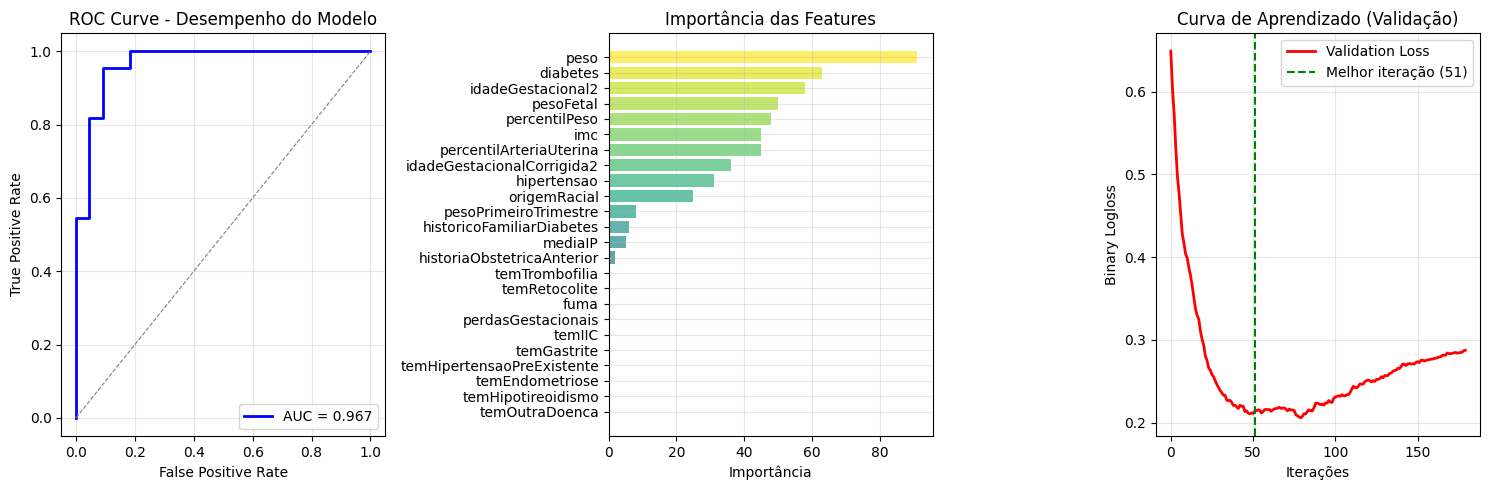

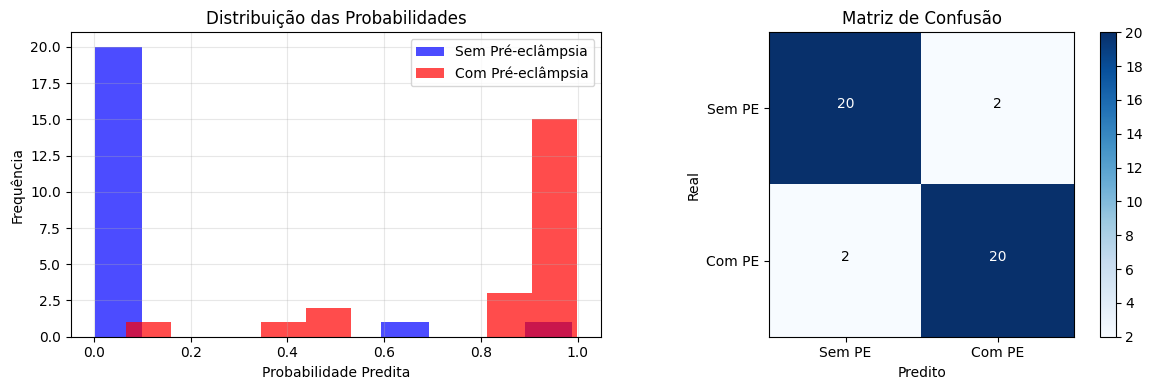


🔍 TOP 10 FEATURES MAIS IMPORTANTES:
  peso                              91
  diabetes                          63
  idadeGestacional2                 58
  pesoFetal                         50
  percentilPeso                     48
  imc                               45
  percentilArteriaUterina           45
  idadeGestacionalCorrigida2        36
  hipertensao                       31
  origemRacial                      25
Threshold usado ≈ 0.409
FPR nesse threshold: 0.091
TPR (sensibilidade) nesse threshold: 0.955

📊 Distribuição da importância:
  Média: 21.4
  Máxima: 91.0 (peso)
  Mínima: 0.0


In [11]:
import os
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    precision_recall_curve,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# CONFIGURAÇÕES
# ------------------------------------------------------------------
DATA_PATH = "/Users/renanmoura/Documents/mestrado/PE-AI/data/dados.xlsx"
MODEL_DIR = "/Users/renanmoura/Documents/mestrado/PE-AI/models"
os.makedirs(MODEL_DIR, exist_ok=True)

TARGET_COL = "PreEclampsia"
INPUT_FEATURES = [
    "peso", "imc", "diabetes", "hipertensao", "pesoPrimeiroTrimestre",
    "origemRacial", "historicoFamiliarDiabetes", "mediaIP",
    "historiaObstetricaAnterior", "perdasGestacionais", "fuma",
    "idadeGestacional2", "idadeGestacionalCorrigida2", "pesoFetal",
    "percentilArteriaUterina", "percentilPeso", "temHipertensaoPreExistente",
    "temEndometriose", "temHipotireoidismo", "temIIC", "temTrombofilia",
    "temRetocolite", "temGastrite", "temOutraDoenca"
]

# ------------------------------------------------------------------
# PRÉ-PROCESSAMENTO
# ------------------------------------------------------------------
def preprocess_dataframe(df):
    map_raca = {"Branco": 1, "Pardo": 2, "Preto": 3}
    map_boolean = {
        "Sim": 1, "YES": 1, "SIM": 1, "TRUE": 1,
        "Nao": 0, "NAO": 0, "Não": 0, "NÃO": 0, "FALSE": 0
    }
    map_hist_diabetes = {
        "Não": 0, "NAO": 0, "NÃO": 0, "Nao": 0,
        "1º grau": 3, "1° GRAU": 3, "1 GRAU": 3,
        "2º grau": 2, "2° GRAU": 2, "2 GRAU": 2,
        "3º grau": 1, "3° GRAU": 1, "3 GRAU": 1
    }

    df_processed = df.copy()

    if "origemRacial" in df_processed.columns:
        df_processed["origemRacial"] = (
            df_processed["origemRacial"].replace(map_raca).astype(float)
        )

    cols_bool = ["diabetes", "fuma", "PreEclampsia", "hipertensao"]
    for col in cols_bool:
        if col in df_processed.columns:
            df_processed[col] = (
                df_processed[col].replace(map_boolean).astype(float)
            )

    if "historicoFamiliarDiabetes" in df_processed.columns:
        df_processed["historicoFamiliarDiabetes"] = (
            df_processed["historicoFamiliarDiabetes"]
            .astype(str).str.strip()
            .replace(map_hist_diabetes).astype(float)
        )

    if "historiaObstetricaAnterior" in df_processed.columns:
        df_processed["historiaObstetricaAnterior"] = pd.to_numeric(
            df_processed["historiaObstetricaAnterior"], errors="coerce"
        )
    if "perdasGestacionais" in df_processed.columns:
        df_processed["perdasGestacionais"] = pd.to_numeric(
            df_processed["perdasGestacionais"], errors="coerce"
        )

    doenca_cols = [
        "temHipertensaoPreExistente", "temEndometriose", "temHipotireoidismo",
        "temIIC", "temTrombofilia", "temRetocolite", "temGastrite", "temOutraDoenca"
    ]
    for col in doenca_cols:
        if col not in df_processed.columns:
            df_processed[col] = 0

    if "doencaPreExistente" in df_processed.columns:
        doenca_text = df_processed["doencaPreExistente"].astype(str).str.lower()
        df_processed["temHipertensaoPreExistente"] = doenca_text.str.contains("hipertens", na=False).astype(int)
        df_processed["temEndometriose"]           = doenca_text.str.contains("endometriose", na=False).astype(int)
        df_processed["temHipotireoidismo"]        = doenca_text.str.contains("hipotireoid", na=False).astype(int)
        df_processed["temTrombofilia"]            = doenca_text.str.contains("trombofilia", na=False).astype(int)
        df_processed["temGastrite"]               = doenca_text.str.contains("gastrite", na=False).astype(int)
        outras_condicoes = doenca_text.str.contains("diabetes|asma|depress|ansiedade|outra", na=False)
        df_processed["temOutraDoenca"] = (
            outras_condicoes &
            ~df_processed[[
                "temHipertensaoPreExistente", "temEndometriose",
                "temHipotireoidismo", "temTrombofilia", "temGastrite"
            ]].any(axis=1)
        ).astype(int)

    for col in INPUT_FEATURES:
        if col in df_processed.columns:
            df_processed[col] = pd.to_numeric(df_processed[col], errors="coerce")
        else:
            df_processed[col] = 0.0

    for col in INPUT_FEATURES:
        df_processed[col] = df_processed[col].fillna(0)

    def aplicar_limites_realistas(X, feature_names):
        limites = {
            "peso": (40, 150),
            "imc": (15, 50),
            "pesoPrimeiroTrimestre": (35, 150),
            "pesoFetal": (0, 5000),
        }
        X = X.copy()
        for feat, (low, high) in limites.items():
            if feat in feature_names:
                X[feat] = X[feat].clip(lower=low, upper=high)
        return X

    df_processed[INPUT_FEATURES] = aplicar_limites_realistas(
        df_processed[INPUT_FEATURES], INPUT_FEATURES
    )

    df_processed = df_processed[~df_processed[TARGET_COL].isna()]
    df_processed[TARGET_COL] = df_processed[TARGET_COL].astype(int)
    return df_processed

# ------------------------------------------------------------------
# PIPELINE PRINCIPAL
# ------------------------------------------------------------------
df_raw = pd.read_excel(DATA_PATH)
if "PacienteId" not in df_raw.columns:
    raise ValueError("Coluna 'PacienteId' obrigatória.")

df_processed = preprocess_dataframe(df_raw)
df3 = df_processed.copy()
df3 = df3[~df3[TARGET_COL].isna()]
df3[TARGET_COL] = df3[TARGET_COL].astype(int)

X_all = df3[INPUT_FEATURES].copy()
y_all = df3[TARGET_COL].copy()
groups = df3["PacienteId"].values

gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
train_idx, test_idx = next(gss.split(X_all, y_all, groups=groups))
X_train = X_all.iloc[train_idx].reset_index(drop=True)
X_test  = X_all.iloc[test_idx].reset_index(drop=True)
y_train = y_all.iloc[train_idx].reset_index(drop=True)
y_test  = y_all.iloc[test_idx].reset_index(drop=True)

X_train_np = X_train.values.astype(float)
X_test_np  = X_test.values.astype(float)
y_train_np = y_train.values
y_test_np  = y_test.values

# Normalização
mean_ = X_train_np.mean(axis=0)
std_ = X_train_np.std(axis=0) + 1e-8
X_train_np = (X_train_np - mean_) / std_
X_test_np  = (X_test_np  - mean_) / std_

with open(os.path.join(MODEL_DIR, "nn_norm_stats_24f.json"), "w") as f:
    json.dump({"mean": mean_.tolist(), "std": std_.tolist()}, f)

# ------------------------------------------------------------------
# REDE NEURAL (sem SMOTE, só class_weight)
# ------------------------------------------------------------------
if len(np.unique(y_train_np)) <= 1:
    raise RuntimeError("Apenas uma classe disponível.")

model = Sequential([
    Input(shape=(X_train_np.shape[1],)),
    Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])
model.compile(
    optimizer=Adam(learning_rate=0.0007),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

cw_vals = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_np),
    y=y_train_np
)
class_weights_dict = dict(enumerate(cw_vals))

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True
)

history = model.fit(
    X_train_np, y_train_np,
    epochs=80,
    batch_size=16,
    validation_data=(X_test_np, y_test_np),
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
)

nn_path = os.path.join(MODEL_DIR, "nn_preeclampsia_24f_nosmote.keras")
model.save(nn_path)
print("✅ Modelo salvo em:", nn_path)

# ------------------------------------------------------------------
# AVALIAÇÃO NUMÉRICA
# ------------------------------------------------------------------
y_pred_prob = model.predict(X_test_np).ravel()
auc = roc_auc_score(y_test_np, y_pred_prob)
print(f"\nROC AUC (NN): {auc:.4f}")

threshold_default = 0.2
y_pred = (y_pred_prob >= threshold_default).astype(int)

print("\n📌 Avaliação por múltiplos thresholds:")
for t in [0.1, 0.2, 0.3, 0.4, 0.5]:
    y_pred_t = (y_pred_prob >= t).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test_np, y_pred_t,
        average="binary",
        zero_division=0
    )
    print(f"Threshold {t:.2f} → Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

print(f"\n📌 Classification Report (threshold = {threshold_default}):")
print(classification_report(y_test_np, y_pred, zero_division=0))

# ------------------------------------------------------------------
# GRÁFICOS ESTILO LIGHTGBM
# ------------------------------------------------------------------
print("=== GRÁFICOS (NN) ===")

# 1) ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_np, y_pred_prob)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2, color="blue")
plt.plot([0, 1], [0, 1], "--", linewidth=0.8, color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - NN Pré-Eclâmpsia")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# 2) "Feature importance" – placeholder: sem importância nativa, então só plotamos nada ou um texto
plt.subplot(1, 3, 2)
plt.axis("off")
plt.text(
    0.0, 0.5,
    "NN não possui\nfeature_importances_\ncomo o LightGBM.\n\nSugestão: usar SHAP\nem outro script.",
    fontsize=11, va="center"
)
plt.title("Importância de Features (não disponível\nnativamente para NN)")

# 3) Curva de aprendizado (loss de validação)
plt.subplot(1, 3, 3)
plt.plot(history.history["loss"], label="Train Loss", linewidth=2, color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", linewidth=2, color="red")
plt.xlabel("Épocas")
plt.ylabel("Binary Crossentropy")
plt.title("Curva de Aprendizado (Loss)")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Distribuição das probabilidades por classe
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
prob_class_0 = y_pred_prob[y_test_np == 0]
prob_class_1 = y_pred_prob[y_test_np == 1]

plt.hist(prob_class_0, alpha=0.7, label="Sem PE", bins=10, color="blue")
plt.hist(prob_class_1, alpha=0.7, label="Com PE", bins=10, color="red")
plt.xlabel("Probabilidade predita (classe 1)")
plt.ylabel("Frequência")
plt.title("Distribuição das Probabilidades (NN)")
plt.legend()
plt.grid(alpha=0.3)

# Matriz de confusão
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test_np, y_pred)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Matriz de Confusão - NN")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Sem PE", "Com PE"])
plt.yticks(tick_marks, ["Sem PE", "Com PE"])

thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(
        j, i, format(cm[i, j], "d"),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black"
    )

plt.ylabel("Real")
plt.xlabel("Predito")
plt.tight_layout()
plt.show()

# Threshold mais próximo de 0.5 na ROC
cutoff = 0.5
idx_thr = (np.abs(thresholds - cutoff)).argmin()
print(f"\nThreshold ~0.5 na ROC: {thresholds[idx_thr]:.3f}")
print(f"FPR nesse threshold: {fpr[idx_thr]:.3f}")
print(f"TPR (sensibilidade) nesse threshold: {tpr[idx_thr]:.3f}")

# ------------------------------------------------------------------
# Função predict_case COM normalização
# ------------------------------------------------------------------
with open(os.path.join(MODEL_DIR, "nn_norm_stats_24f.json")) as f:
    norm_stats_loaded = json.load(f)
mean_loaded = np.array(norm_stats_loaded["mean"])
std_loaded  = np.array(norm_stats_loaded["std"]) + 1e-8

def predict_case(sample: dict) -> float:
    arr = []
    for col in INPUT_FEATURES:
        arr.append(float(sample.get(col, 0)))
    Xp = np.array(arr).reshape(1, -1)
    Xp = (Xp - mean_loaded) / std_loaded
    prob = float(model.predict(Xp)[0, 0])
    return prob


In [12]:
# %% Cell 11 - Teste com dados da API
print("=== TESTE PARA API ===")

# Dados de exemplo
dados_teste_api = {
  "peso": 105.0,
  "imc": 36.5,                     # obesidade
  "diabetes": 1,                   # diabetes presente
  "hipertensao": 1,                # hipertensão na gestação
  "pesoPrimeiroTrimestre": 100.0,
  "origemRacial": "Preto",
  "historicoFamiliarDiabetes": 3,  # forte histórico familiar
  "mediaIP": 1.60,                 # Doppler bem elevado
  "historiaObstetricaAnterior": 2, # gesta prévia
  "perdasGestacionais": 1,
  "fuma": 1,
  "idadeGestacional2": 29.0,
  "idadeGestacionalCorrigida2": 28.5,
  "pesoFetal": 1500,
  "percentilArteriaUterina": 90,   # percentil alto
  "percentilPeso": 20,             # possível RCF
  "temHipertensaoPreExistente": 1, # HAS crônica
  "temEndometriose": 0,
  "temHipotireoidismo": 1,
  "temIIC": 0,
  "temTrombofilia": 1,             # trombofilia
  "temRetocolite": 0,
  "temGastrite": 0,
  "temOutraDoenca": 0
}

# Função de pré-processamento para API
def preprocess_input_data(input_data):
    input_df = pd.DataFrame([input_data])
    
    # Aplicar transformações
    if "origemRacial" in input_df.columns:
        input_df["origemRacial"] = input_df["origemRacial"].replace(map_raca)
    
    for col in cols_bool:
        if col in input_df.columns:
            input_df[col] = input_df[col].replace(map_boolean).astype("float").astype("Int64")
    
    if "historicoFamiliarDiabetes" in input_df.columns:
        input_df["historicoFamiliarDiabetes"] = input_df["historicoFamiliarDiabetes"].astype(str).str.strip().replace(map_hist_diabetes).astype(float)
    
    # Garantir todas as 24 features
    for feature in input_features:
        if feature not in input_df.columns:
            input_df[feature] = 0  # valor padrão para features faltantes
    
    return input_df[input_features]

# Testar
dados_processados = preprocess_input_data(dados_teste_api)
probabilidade = trained_model.predict_proba(dados_processados)[0, 1]

print(f"✅ TESTE BEM-SUCEDIDO!")
print(f"Probabilidade de Pré-eclâmpsia: {probabilidade:.3f}")
print(f"Predição: {'ALTO RISCO' if probabilidade > 0.5 else 'baixo risco'}")
print(f"Shape dos dados processados: {dados_processados.shape}")
print(f"Features utilizadas: {len(input_features)}")

=== TESTE PARA API ===
✅ TESTE BEM-SUCEDIDO!
Probabilidade de Pré-eclâmpsia: 0.986
Predição: ALTO RISCO
Shape dos dados processados: (1, 24)
Features utilizadas: 24


/var/folders/g6/grvwn5y16hnbc_vmrhqpzkmm0000gn/T/ipykernel_2601/33266791.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  input_df["origemRacial"] = input_df["origemRacial"].replace(map_raca)
/Users/renanmoura/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/renanmoura/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [13]:
for i, col in enumerate(X.columns):
    print(i, col)

0 peso
1 imc
2 diabetes
3 hipertensao
4 pesoPrimeiroTrimestre
5 origemRacial
6 historicoFamiliarDiabetes
7 mediaIP
8 historiaObstetricaAnterior
9 perdasGestacionais
10 fuma
11 idadeGestacional2
12 idadeGestacionalCorrigida2
13 pesoFetal
14 percentilArteriaUterina
15 percentilPeso
16 temHipertensaoPreExistente
17 temEndometriose
18 temHipotireoidismo
19 temIIC
20 temTrombofilia
21 temRetocolite
22 temGastrite
23 temOutraDoenca
